In [37]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### 单变量ARIMA预测，多变量用ARIMA需要创建多个模型

- ARIMA模型需要以时间序列为索引index。acf、pacf图也需要

In [77]:
etth1='public/ETTh1.csv'
etth1 = pd.read_csv(etth1)
etth1['date'] = pd.to_datetime(etth1['date'])
etth1.set_index('date',inplace=True)
etth1.head(10)

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000
2016-07-01 06:00:00,7.167,2.947,2.132,0.782,5.026,1.858,22.792000
2016-07-01 07:00:00,7.435,3.282,2.310,1.031,5.087,2.224,23.143999
2016-07-01 08:00:00,5.559,3.014,2.452,1.173,2.955,1.432,21.667000


In [79]:
etth1_W = etth1.resample('D').mean()
data = etth1_W
data.head(10),len(data)

(                 HUFL      HULL      MUFL      MULL      LUFL      LULL   
 date                                                                      
 2016-07-01   5.322042  2.603625  1.986958  0.898750  3.312333  1.496208  \
 2016-07-02   8.009500  4.108208  5.127417  2.009125  2.868292  1.639750   
 2016-07-03  10.496333  4.995625  7.176625  2.542208  3.326417  1.879458   
 2016-07-04  10.501875  5.408583  6.956125  2.728833  3.353000  1.906208   
 2016-07-05  11.369917  5.377833  7.711125  2.682833  3.545917  2.014042   
 2016-07-06  10.800500  4.738875  7.414917  2.292083  3.224833  1.813625   
 2016-07-07  11.802375  4.853208  8.617292  2.465292  3.101708  1.672625   
 2016-07-08  11.481458  4.591000  7.934750  2.246083  3.426750  1.719667   
 2016-07-09  11.849958  4.532292  8.291542  2.130583  3.394917  1.714542   
 2016-07-10  11.196750  4.015958  7.293500  1.727875  3.783250  1.665208   
 
                    OT  
 date                   
 2016-07-01  21.071833  
 2016-07-02

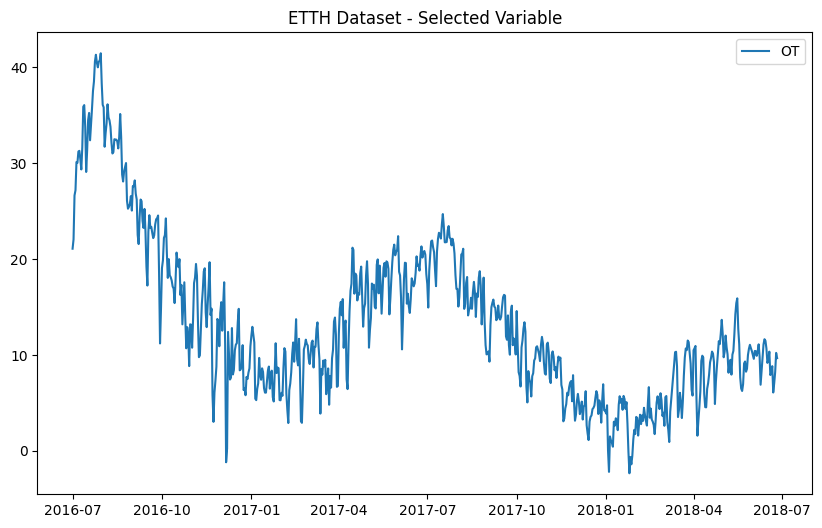

In [80]:
# 选择要预测的变量
target_variable = 'OT'

# 可视化选择的变量
plt.figure(figsize=(10, 6))
plt.plot(data[target_variable], label=target_variable)
plt.title('ETTH Dataset - Selected Variable')
plt.legend()
plt.show()

### 做一阶差分，使数据更平稳
- 实际一般做一个一阶差分也就够了

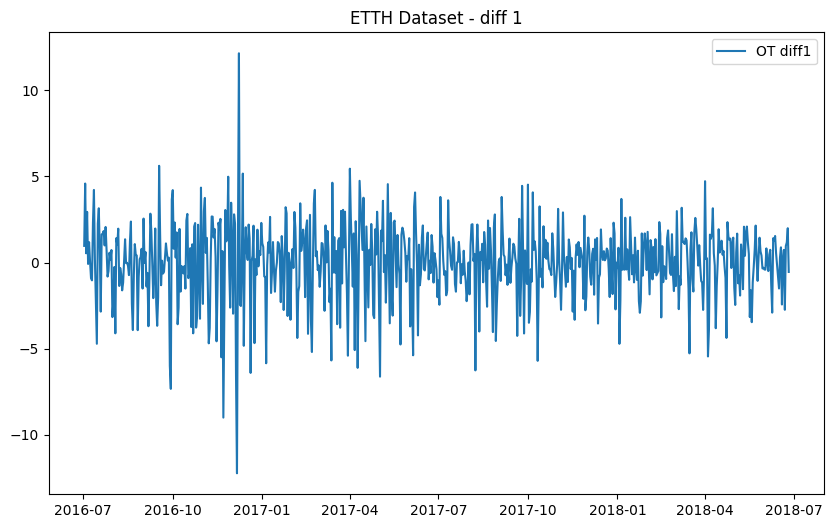

In [81]:
# 差分
# 差分要存入一个新变量，不然后面画ACF图，会出错
data_diff = data[target_variable].diff()
# 差分后可能会出现0值，要去掉，一般固定操作
data_diff = data_diff.dropna()

# 可视化选择的变量
plt.figure(figsize=(10, 6))
plt.plot(data_diff, label=f'{target_variable}' +' diff1')
plt.title('ETTH Dataset - diff 1')
plt.legend()
plt.show()

### 画ACF与PACF图
- 怎么根据图选择pq还要看下

<Figure size 1200x600 with 0 Axes>

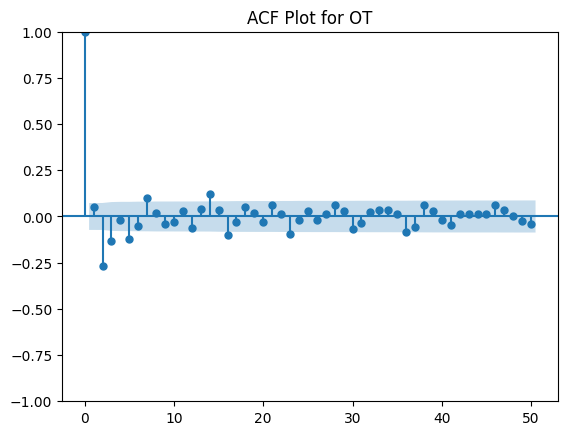

In [82]:


# 画出ACF图
plt.figure(figsize=(12, 6))
plot_acf(data_diff, lags=50, title=f'ACF Plot for {target_variable}')
plt.show()

- 上图2阶还没落在置信区间，所以p选1

<Figure size 1200x600 with 0 Axes>

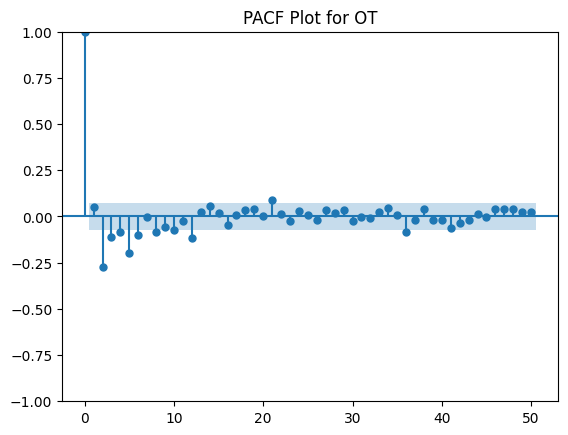

In [83]:
# 画出PACF图
plt.figure(figsize=(12,6))
plot_pacf(data_diff,lags=50,title=f'PACF Plot for {target_variable}')
plt.show()

-  上图2阶还没落在置信区间，所以q选1

In [74]:
# 拆分数据集为训练集和测试集
train_size = int(len(data_diff) * 0.8)
train, test = data_diff[:train_size], data_diff[train_size:]
test,len(train),len(test)

(date
 2018-02-12    0.631369
 2018-02-19    0.699321
 2018-02-26    0.363458
 2018-03-05   -0.168756
 2018-03-12    0.820738
 2018-03-19    1.823964
 2018-03-26    1.492351
 2018-04-02    0.739893
 2018-04-09   -3.231310
 2018-04-16    0.973548
 2018-04-23    1.898542
 2018-04-30    1.847446
 2018-05-07   -0.154119
 2018-05-14    0.013857
 2018-05-21    0.300637
 2018-05-28   -1.816500
 2018-06-04    1.390577
 2018-06-11   -0.948363
 2018-06-18    1.131393
 2018-06-25   -2.494798
 2018-07-02    1.610189
 Freq: W-MON, Name: OT, dtype: float64,
 83,
 21)

In [84]:
# 定义ARIMA模型
order = (2, 1, 2)
model = ARIMA(train, order=order)

d:\Software\CodeApp\Anaconda\envs\test\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Software\CodeApp\Anaconda\envs\test\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


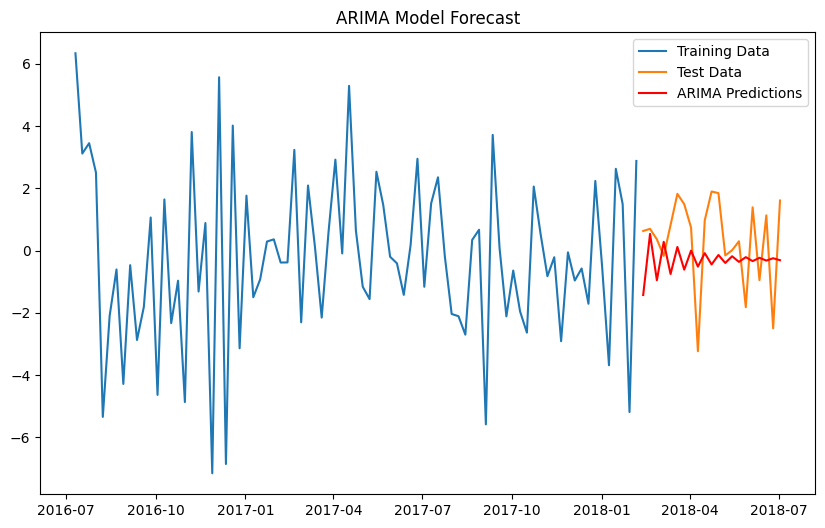

Mean Squared Error: 2.4730095620726646


In [85]:
# 拟合模型
model_fit = model.fit()

# 预测未来值
forecast_steps = len(test)
predictions = model_fit.forecast(steps=forecast_steps)

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

# 评估模型性能
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

In [86]:
from statsmodels.graphics.api import qqplot #画QQ图,检验一组数据是否服从正态分布
resid=model.resid
qqplot(resid, line='q', fit=True).show()
plt.pause(100)

AttributeError: 'ARIMA' object has no attribute 'resid'